In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import requests
cases_request = requests.get('https://coronavirus-tracker-api.herokuapp.com/confirmed')
deaths_request = requests.get('https://coronavirus-tracker-api.herokuapp.com/deaths')
recovered_request = requests.get('https://coronavirus-tracker-api.herokuapp.com/recovered')
cases_json_data = cases_request.json()
deaths_json_data = deaths_request.json()
recovered_json_data = recovered_request.json()

In [3]:
def transform_data(json_data, number_field_name):
    """Function that transforms the full json-data into a list of small dict-objects. 
    
    Each object states for a single day in a single country.
    """
    complete_list = []
    for country_data in json_data['locations']:
        for history_date, number in country_data['history'].items():
            if history_date == 'latest':
                continue
            day_data = {'country': country_data['country'], 'date_text': history_date, number_field_name: number}
            complete_list.append(day_data)
    return complete_list

cases_list = transform_data(cases_json_data, 'number_of_cases')
deaths_list = transform_data(deaths_json_data, 'number_of_deaths')
recovered_list = transform_data(deaths_json_data, 'number_of_recovered')
cases_list[:5]

[{'country': 'Afghanistan', 'date_text': '1/22/20', 'number_of_cases': 0},
 {'country': 'Afghanistan', 'date_text': '1/23/20', 'number_of_cases': 0},
 {'country': 'Afghanistan', 'date_text': '1/24/20', 'number_of_cases': 0},
 {'country': 'Afghanistan', 'date_text': '1/25/20', 'number_of_cases': 0},
 {'country': 'Afghanistan', 'date_text': '1/26/20', 'number_of_cases': 0}]

In [4]:
import pandas as pd
cases_df = pd.DataFrame(cases_list)
deaths_df = pd.DataFrame(deaths_list)
recovered_df = pd.DataFrame(recovered_list)

complete_df = deaths_df.merge(cases_df, on=['country', 'date_text'])
complete_df = complete_df.merge(recovered_df, on=['country', 'date_text'])
complete_df.head()

,country,date_text,number_of_deaths,number_of_cases,number_of_recovered
0,Afghanistan,1/22/20,0,0,0
1,Afghanistan,1/23/20,0,0,0
2,Afghanistan,1/24/20,0,0,0
3,Afghanistan,1/25/20,0,0,0
4,Afghanistan,1/26/20,0,0,0


In [5]:
from datetime import date, timedelta, datetime
from matplotlib import pyplot as plt
from datetime import date, datetime

#Set a country and the date of the epidemic's start
country = 'Italy'
start_date = date(2020, 2, 10)

# Filter dataframe by country and dates
country_df = complete_df[complete_df['country'] == country]
country_df['date'] = country_df['date_text'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').date())
country_df['days'] = country_df['date'].apply(lambda x: (x - start_date).days)
country_df = country_df[country_df['days'] >= 0]
country_df = country_df.sort_values(by='days')
country_df.head()

,country,date_text,number_of_deaths,number_of_cases,number_of_recovered,date,days
2823706,Italy,2/10/20,0,3,0,2020-02-10,0
2823707,Italy,2/11/20,0,3,0,2020-02-11,1
2823708,Italy,2/12/20,0,3,0,2020-02-12,2
2823709,Italy,2/13/20,0,3,0,2020-02-13,3
2823710,Italy,2/14/20,0,3,0,2020-02-14,4


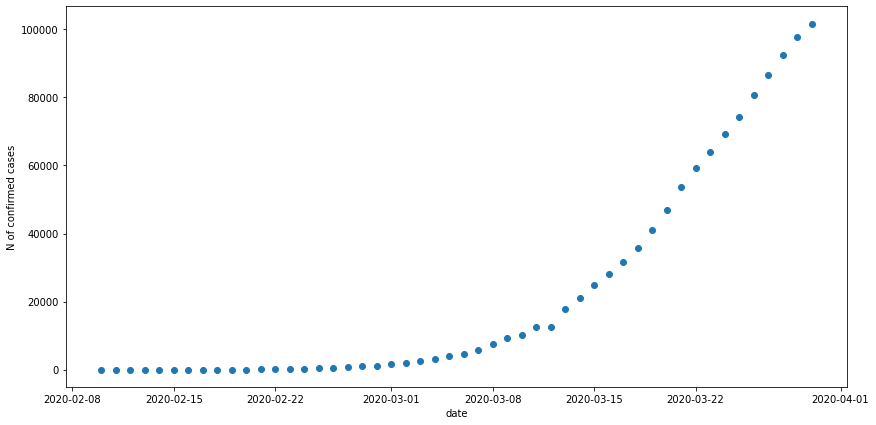

In [6]:
plt.figure(figsize=(14, 7))
plt.scatter(country_df['date'], country_df['number_of_cases'])
plt.xlabel('date')
plt.ylabel('N of confirmed cases')
plt.show()

In [7]:
from scipy.optimize import curve_fit
import numpy as np

def sigmoid(x, m, k, x0):
    """The standard logistic function."""
    return m / (1 + np.exp(-k * (x - x0)))

x_train = country_df['days'].to_numpy()
y_train = country_df['number_of_cases'].to_numpy()

params, __ = curve_fit(sigmoid, x_train, y_train)
params.tolist()

[128726.87423449046, 0.1863097896258783, 42.04219872408674]

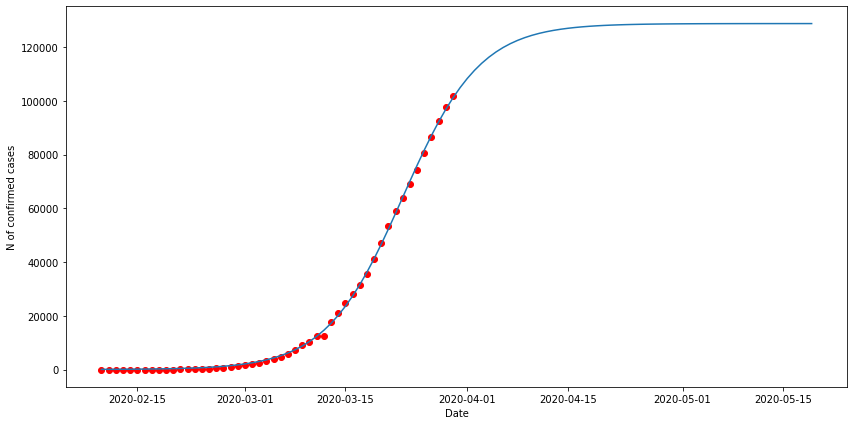

In [8]:
m, k, x0 = params.tolist()
days_to_predict = np.array(list(range(100)))
prediction_dates_list = [start_date + timedelta(days=i) for i in range(100)]
predicted_cases = sigmoid(days_to_predict, m, k, x0)
hictorical_dates = country_df['date']

plt.figure(figsize=(14,7))
plt.scatter(hictorical_dates, country_df['number_of_cases'], color='r')
plt.plot(prediction_dates_list, predicted_cases)
plt.xlabel('Date')
plt.ylabel('N of confirmed cases')
plt.show()

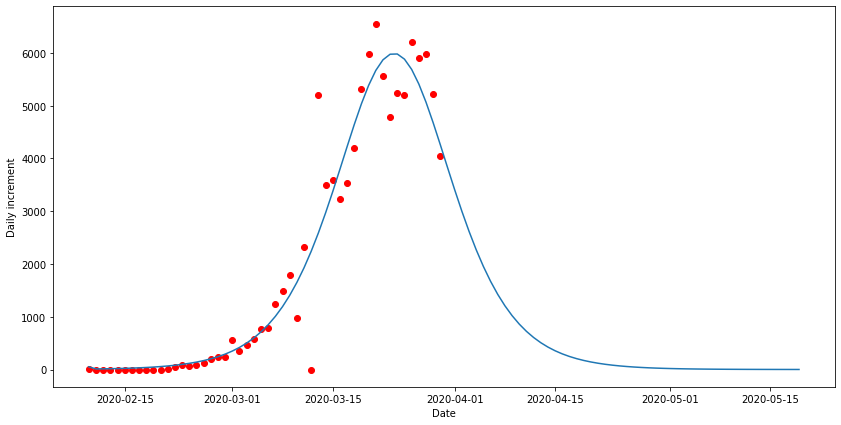

In [9]:
def get_new_daily_cases(cumulative_cases_list):
    """The function that transforms a list of accumulated daily cases to a list of new cases."""
    days_number = len(cumulative_cases_list)
    daily_cases = [cumulative_cases_list[i + 1] - cumulative_cases_list[i] for i in range(days_number - 1)]
    # Add the first day cases number as the first day increment
    daily_cases = [cumulative_cases_list[0]] + daily_cases
    return daily_cases

predicted_cases_list = predicted_cases.tolist()
predicted_daily_new_cases = get_new_daily_cases(predicted_cases_list)
historical_cases_list = y_train.tolist()
historical_daily_new_cases = get_new_daily_cases(historical_cases_list)

# Plot the real and predicted daily increments
plt.figure(figsize=(14,7))
plt.scatter(hictorical_dates, historical_daily_new_cases, color='r')
plt.plot(prediction_dates_list, predicted_daily_new_cases)
plt.xlabel('Date')
plt.ylabel('Daily increment')
plt.show()